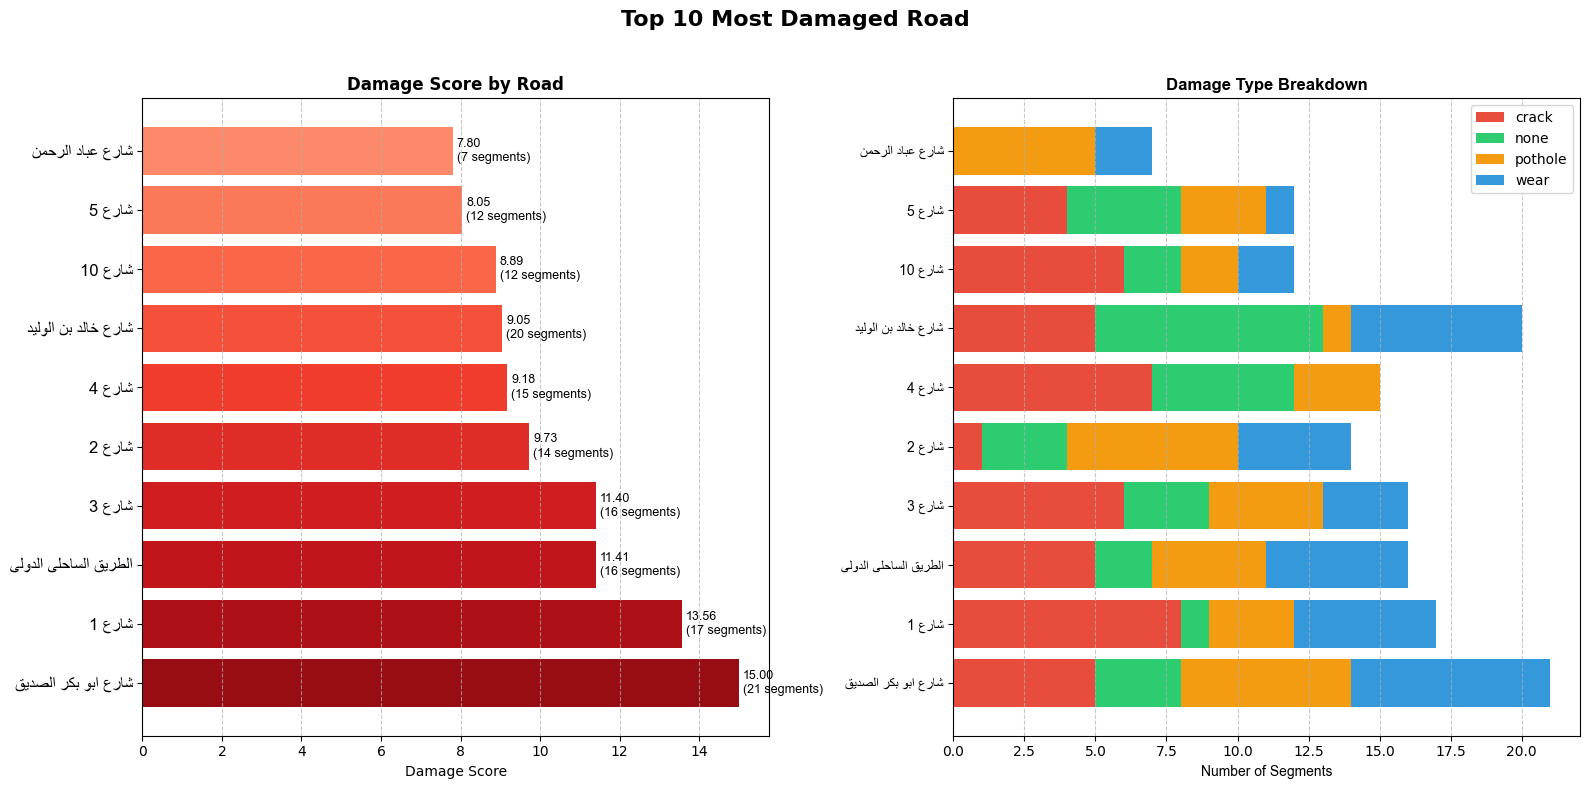

Damage Scoring Formula:
Damage Score = (Crack_Count * 1.0 + Pothole_Count * 1.5 + Wear_Count * 0.7) * Average_Confidence

Weights:
- Crack: 1.0
- Pothole: 1.5 (more severe)
- Wear: 0.7 (less severe)
- Confidence: Multiplicative factor (higher confidence = higher score)


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import arabic_reshaper
from bidi.algorithm import get_display

file_path = r'D:\DEPI PROJECT PAVEMENT EYE\sample.geojson'

with open(file_path, 'r', encoding="utf-8") as f: 
    geojson_data = json.load(f)

def format_arabic(text):
    if isinstance(text, str) and any('\u0600' <= c <= '\u06FF' for c in text):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

road_data = []
for feature in geojson_data['features']:
    props = feature['properties']
    name = props.get('name', 'Unnamed Road')
    label = props.get('label', 'none')
    confidence = props.get('confidence', 0.5)
    
   # damage calculator
    if label == 'crack':
        damage_weight = 1.0
    elif label == 'pothole':
        damage_weight = 1.5
    elif label == 'wear':
        damage_weight = 0.7
    else:  #none
        damage_weight = 0
        
    damage_score = damage_weight * confidence
    road_data.append({'name': name, 'label': label, 'confidence': confidence, 'damage_score': damage_score})

df = pd.DataFrame(road_data)

road_damage = df.groupby('name').agg({
    'damage_score': 'sum',
    'label': 'count'  
}).rename(columns={'label': 'segment_count'}).reset_index()

top_10_damaged = road_damage.nlargest(10, 'damage_score')


top_10_damaged['display_name'] = top_10_damaged['name'].apply(format_arabic)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # Increased figure size
fig.suptitle('Top 10 Most Damaged Road' , fontsize=16, fontweight='bold')

#bar char for those top 10 
bars = ax1.barh(range(len(top_10_damaged)), top_10_damaged['damage_score'], 
                color=plt.cm.Reds(np.linspace(0.9,0.4, len(top_10_damaged))))
ax1.set_yticks(range(len(top_10_damaged)))
ax1.set_yticklabels(top_10_damaged['display_name'], fontname='Arial', fontsize=12)
ax1.set_xlabel('Damage Score' , fontsize=10)
ax1.set_title('Damage Score by Road' , fontsize=12, fontweight='bold')
ax1.grid(axis='x', linestyle='--', alpha=0.7)



for i, (score, count) in enumerate(zip(top_10_damaged['damage_score'], top_10_damaged['segment_count'])):
    ax1.text(score + 0.1, i, f'{score:.2f}\n({count} segments)', 
             va='center', fontsize=9, fontname='Arial')


damage_types = df[df['name'].isin(top_10_damaged['name'])]
damage_breakdown = pd.crosstab(damage_types['name'], damage_types['label'])


damage_breakdown = damage_breakdown.reindex(top_10_damaged['name'])


damage_breakdown_display = damage_breakdown.copy()
damage_breakdown_display.index = top_10_damaged['display_name']

bottom = np.zeros(len(damage_breakdown))
colors = {'crack': '#e74c3c', 'pothole': '#f39c12', 'wear': '#3498db', 'none': '#2ecc71'}

for damage_type in damage_breakdown.columns:
    counts = damage_breakdown[damage_type].values
    ax2.barh(range(len(damage_breakdown)), counts, left=bottom, 
             label=damage_type, color=colors.get(damage_type, 'gray'))
    bottom += counts

ax2.set_yticks(range(len(damage_breakdown_display)))
ax2.set_yticklabels(damage_breakdown_display.index, fontname='Arial', fontsize=10)
ax2.set_xlabel('Number of Segments', fontname='Arial', fontsize=10)
ax2.set_title('Damage Type Breakdown', fontname='Arial', fontsize=12, fontweight='bold')

ax2.legend(loc='upper right')
ax2.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#print the used formula 
print("Damage Scoring Formula:")
print("Damage Score = (Crack_Count * 1.0 + Pothole_Count * 1.5 + Wear_Count * 0.7) * Average_Confidence")
print("\nWeights:")
print("- Crack: 1.0")
print("- Pothole: 1.5 (more severe)")
print("- Wear: 0.7 (less severe)")
print("- Confidence: Multiplicative factor (higher confidence = higher score)")